##### Import Libraries

In [165]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing

##### Import futures data, then pre-process

In [166]:
df_2024 = pd.read_parquet('Futures_2024.parquet', engine='pyarrow')
df_2023 = pd.read_parquet('Futures_2023.parquet', engine='pyarrow')

In [167]:
df = pd.concat([df_2023, df_2024])
df = df[[col for col in df.columns if 'Close' in col]]
df.index = pd.to_datetime(df.index)

filter1 = df.dropna(axis=1, thresh=138428)
filter2 = filter1.loc[:, (df != 0).all(axis=0)]
base_df = filter2.resample('D',origin='2023-01-02 09:15:00').last().dropna()

##### Import nifty data and pre-process

In [168]:
df_nifty=pd.read_parquet('Idx_fut.parquet', engine='pyarrow')
df_nifty = df_nifty[[col for col in df_nifty if 'NIFTY_Close' in col]]
df_nifty.index = pd.to_datetime(df_nifty.index)
df_nifty = df_nifty[df_nifty.index > '2023-01-02 09:15:00']
nifty_frame = df_nifty.resample('D',origin='2023-01-02 09:15:00').last().dropna()
nifty_frame.drop(columns = 'BANKNIFTY_Close', inplace=True)
nifty_frame = nifty_frame[nifty_frame.index <'2024-07-02 15:15:00']

##### Calculate relative prices

In [169]:
rel_prices = base_df.div(nifty_frame['NIFTY_Close'], axis=0)

##### Select only stocks from nifty

In [170]:
nifty_50 = ["MARUTI_Close", "ITC_Close", "M&M_Close", "TITAN_Close", "EICHERMOT_Close", "HEROMOTOCO_Close", "SBIN_Close", "HINDUNILVR_Close", "TATAMOTORS_Close", "LT_Close", "ICICIBANK_Close", "BAJAJFINSV_Close", "HDFCLIFE_Close", "SBILIFE_Close", "JSWSTEEL_Close", "HINDALCO_Close", "ASIANPAINT_Close", "ADANIPORTS_Close", "HDFCBANK_Close", "COALINDIA_Close", "TCS_Close", "INFY_Close", "NTPC_Close", "AXISBANK_Close", "APOLLOHOSP_Close", "TATASTEEL_Close", "BHARTIARTL_Close", "ADANIENT_Close", "INDUSINDBK_Close", "TECHM_Close", "KOTAKBANK_Close", "BAJFINANCE_Close", "BPCL_Close", "SHRIRAMFIN_Close", "RELIANCE_Close", "ONGC_Close"]
stock_prices = base_df[nifty_50]
relative_prices = rel_prices[nifty_50]

##### Pre-process lot sizes for each stock

In [171]:
multiplier = pd.read_csv('instrument_list.csv')
multiplier = multiplier.drop(columns=[col for col in multiplier.columns if col not in ['name', 'segment', 'lot_size']])
multiplier_nfo = multiplier[multiplier['segment'] == 'NFO-FUT']
filtered_df = multiplier_nfo.drop_duplicates(subset='name', keep='first')
valid_stocks = filtered_df['name'].unique()
valid_stock_columns = [f"{stock}_Close" for stock in valid_stocks]
columns_to_keep = [col for col in valid_stock_columns if col in stock_prices.columns]
filtered_price_df = stock_prices[columns_to_keep]
filtered_stock_names = [col.split('_')[0] for col in filtered_price_df.columns]
filtered_multiplier_df = filtered_df[filtered_df['name'].isin(filtered_stock_names)]
filtered_multiplier_df.drop(columns = 'segment', inplace=True)
filtered_multiplier_df.set_index('name', inplace=True)
filtered_multiplier_df.columns = ['mult']
mult_list = filtered_multiplier_df
mult_list.index = mult_list.index + '_Close'
filtered_multiplier_df = filtered_df[filtered_df['name'].isin(filtered_stock_names)]

C:\Users\Guest_Account\AppData\Local\Temp\ipykernel_11980\3156634287.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_multiplier_df.drop(columns = 'segment', inplace=True)


##### Strategy:
- Start with 36 stocks from nifty, and every day rank them based on relative momentum
- Then use strategy 6 from futures strategies : Long/Short futures with variable risk scaling
- For the top n stocks we calculate the position size using a target risk of 20%, then go long if the ema crossover is positive
- For the bottom n we calculate position size then go short if ema crossover negative
- If the position size is too large from Calculate_N, we use the max_exposure as a calculator for position size
- All stocks have max exposure of 1Cr
- Total 20 stocks in portfolio

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class StratSixPortfolio:
    def __init__(self, stock_prices, relative_prices, mult, lookback_period, num_stocks, max_positions, initial_capital=200000000, target_risk=20):
        self.stock_prices = stock_prices
        self.relative_prices = relative_prices
        self.mult = mult
        self.lookback_period = lookback_period
        self.num_stocks = int(min(max_positions // 2, num_stocks))
        self.max_positions = max_positions
        self.available_capital = initial_capital
        self.target_risk = target_risk
        self.current_positions = {stock: 0 for stock in stock_prices.columns}
        self.pnl_series = pd.Series(index=stock_prices.index)
        self.trade_log = []

        self.sd_returns = self.calculate_returns_and_std_dev()
        self.ewma_16, self.ewma_256 = self.calculate_ewma_signals()

    def calculate_momentum(self, data, current_time):
        lookback_time = current_time - pd.Timedelta(days=self.lookback_period)
        if lookback_time in data.index:
            return (data.loc[current_time] / data.loc[lookback_time] - 1)
        else:
            return pd.Series(np.nan, index=data.columns)

    def rank_stocks(self, current_time):
        momentum_scores = self.calculate_momentum(self.relative_prices, current_time)
        ranked_stocks = momentum_scores.sort_values(ascending=False)
        return ranked_stocks

    def calculate_returns_and_std_dev(self):
        returns = (self.stock_prices.diff() / self.stock_prices.shift(1)) * 100
        sd_returns_s = returns.ewm(span=32).std()
        sd_returns_l = returns.ewm(span=700).std()
        sd_returns = 0.3 * sd_returns_l + 0.7 * sd_returns_s
        sd_returns.index = self.stock_prices.index
        return sd_returns * 110  # (*sqrt(252)*sqrt(48)))

    def calculate_ewma_signals(self):
        ewma_16 = self.stock_prices.ewm(span=64).mean()
        ewma_256 = self.stock_prices.ewm(span=256).mean()
        ewma_16.index = self.stock_prices.index
        ewma_256.index = self.stock_prices.index
        return ewma_16, ewma_256

    def calculate_N(self, timestamp, stock):
        price = self.stock_prices.loc[timestamp, stock]
        ewma_16_value = self.ewma_16.loc[timestamp, stock]
        ewma_256_value = self.ewma_256.loc[timestamp, stock]
        sgn = np.sign(ewma_16_value - ewma_256_value)

        num_of_contracts = (self.available_capital * self.target_risk) / (price * self.mult.loc[stock].values * self.sd_returns.loc[timestamp, stock])

        return int(num_of_contracts), sgn

    def allocate_positions(self, ranked_stocks, current_prices, total_positions):
        top_stocks = ranked_stocks.head(self.num_stocks)
        bottom_stocks = ranked_stocks.tail(self.num_stocks)

        long_positions = {}
        short_positions = {}

        top_stocks = [stock for stock in top_stocks.index if self.current_positions[stock] == 0]
        bottom_stocks = [stock for stock in bottom_stocks.index if self.current_positions[stock] == 0]

        max_exp_per_stock = 10000000

        for stock in top_stocks:
            if total_positions < self.max_positions:
                position_size, sgn = self.calculate_N(current_prices.name, stock)
                position_cost = position_size * current_prices[stock] * self.mult.loc[stock].values

                if position_cost > max_exp_per_stock:
                    position_size = int(max_exp_per_stock / (current_prices[stock] * self.mult.loc[stock].values))
                    position_cost = position_size * current_prices[stock] * self.mult.loc[stock].values

                if position_cost <= self.available_capital / 2 and sgn>0:
                    long_positions[stock] = position_size
                    self.trade_log.append({'date': current_prices.name, 'stock': stock, 'position': 'long', 'size': position_size, 'cost': position_cost, 'trading price': current_prices[stock]})

                    total_positions += 1
        
        for stock in bottom_stocks:
            if total_positions < self.max_positions:
                position_size, sgn = self.calculate_N(current_prices.name, stock)
                position_cost = position_size * current_prices[stock] * self.mult.loc[stock].values

                if position_cost > max_exp_per_stock:
                    position_size = int(max_exp_per_stock / (current_prices[stock] * self.mult.loc[stock].values))
                    position_cost = position_size * current_prices[stock] * self.mult.loc[stock].values

                if position_cost <= self.available_capital / 2 and sgn<0:
                    short_positions[stock] = position_size
                    self.trade_log.append({'date': current_prices.name, 'stock': stock, 'position': 'short', 'size': position_size, 'cost': position_cost, 'trading price': current_prices[stock]})
                
                    total_positions +=1
        
        return long_positions, short_positions, total_positions

    def update_positions(self, long_positions, short_positions, previous_prices, current_prices):
        liquidated_pnl = 0
        total_positions = sum(1 for pos in self.current_positions.values() if pos != 0)

        for stock in list(self.current_positions.keys()):
            if stock not in long_positions and stock not in short_positions:
                if self.current_positions[stock] != 0:
                    price_change = current_prices[stock] - previous_prices[stock]
                    liquidated_pnl += self.current_positions[stock] * price_change * self.mult.loc[stock].values
                    self.current_positions[stock] = 0
                    total_positions -= 1

        for stock, position in long_positions.items():
            self.current_positions[stock] = position

        for stock, position in short_positions.items():
            self.current_positions[stock] = -position

        return liquidated_pnl, total_positions

    def calculate_pnl(self, previous_prices, current_prices):
        pnl = 0
        for stock, position in self.current_positions.items():
            price_change = current_prices[stock] - previous_prices[stock]
            pnl += position * price_change * self.mult.loc[stock].values
        return pnl

    def trade(self):
        unique_dates = self.stock_prices.index
        unique_dates = unique_dates[self.lookback_period:]

        next_unique_dates = self.stock_prices.index
        next_unique_dates = next_unique_dates[self.lookback_period - 1:]

        total_positions = sum(1 for pos in self.current_positions.values() if pos != 0)

        for current_time, prev_time in zip(unique_dates, next_unique_dates):
            previous_prices = self.stock_prices.loc[prev_time]
            current_prices = self.stock_prices.loc[current_time]
            ranked_stocks = self.rank_stocks(current_time)
            long_positions, short_positions, total_positions = self.allocate_positions(ranked_stocks, current_prices, total_positions)
            liquidated_pnl, total_positions = self.update_positions(long_positions, short_positions, previous_prices, current_prices)
            pnl = self.calculate_pnl(previous_prices, current_prices) + liquidated_pnl
            self.pnl_series[current_time] = pnl

            self.available_capital += pnl

        return pd.Series(self.pnl_series, index=self.stock_prices.index[self.lookback_period:]).cumsum()


def plot_pnl(pnl_series):
    plt.figure(figsize=(10, 6))
    pnl_series.plot()
    plt.title('Cumulative PnL')
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL')
    plt.grid(True)
    plt.show()




In [173]:
strategy = StratSixPortfolio(stock_prices, relative_prices, mult_list, 10, 7, 20, initial_capital=200000000, target_risk=20)

In [174]:
pnl_series = strategy.trade()

C:\Users\Guest_Account\AppData\Local\Temp\ipykernel_11980\1837359796.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(num_of_contracts), sgn
C:\Users\Guest_Account\AppData\Local\Temp\ipykernel_11980\1837359796.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  position_size = int(max_exp_per_stock / (current_prices[stock] * self.mult.loc[stock].values))
C:\Users\Guest_Account\AppData\Local\Temp\ipykernel_11980\1837359796.py:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (

In [175]:
pnl_series

DateTime
2023-01-16 09:15:00    8.540100e+05
2023-01-17 09:15:00    8.669500e+05
2023-01-18 09:15:00    7.345362e+05
2023-01-19 09:15:00    1.678319e+06
2023-01-20 09:15:00    2.481847e+06
                           ...     
2024-06-26 09:15:00    1.146022e+08
2024-06-27 09:15:00    1.147423e+08
2024-06-28 09:15:00    1.151299e+08
2024-07-01 09:15:00    1.158880e+08
2024-07-02 09:15:00    1.154618e+08
Length: 359, dtype: float64

##### Record trade log

In [176]:
trade_log = pd.DataFrame(strategy.trade_log)

In [186]:
trade_log

,date,stock,position,size,cost,trading price
0,2023-01-16 09:15:00,TATAMOTORS_Close,long,44,[9994600.0],413.00
1,2023-01-16 09:15:00,TECHM_Close,long,16,[9962880.0],1037.80
2,2023-01-16 09:15:00,INDUSINDBK_Close,long,16,[9926800.0],1240.85
3,2023-01-16 09:15:00,HINDALCO_Close,long,14,[9461900.0],482.75
4,2023-01-16 09:15:00,TCS_Close,long,17,[9930550.0],3338.00
...,...,...,...,...,...,...
1752,2024-07-02 09:15:00,EICHERMOT_Close,long,12,[9795344.999999998],4664.45
1753,2024-07-02 09:15:00,HEROMOTOCO_Close,long,11,[9215167.5],5584.95
1754,2024-07-02 09:15:00,SBIN_Close,long,16,[9983400.0],831.95
1755,2024-07-02 09:15:00,KOTAKBANK_Close,short,14,[9943360.0],1775.60


##### Plot cumulative PnL

In [183]:
def plot_pnl(pnl_series):
    plt.figure(figsize=(10, 6))
    pnl_series.plot()
    plt.title('Cumulative PnL')
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL')
    plt.grid(True)
    plt.show()

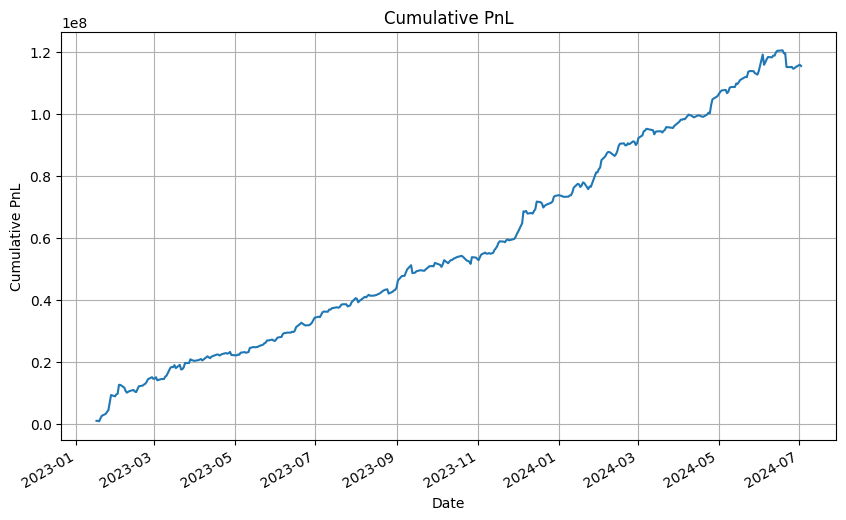

In [184]:
plot_pnl(pnl_series)

##### Some analysis 

In [180]:
initial_cap = 200000000
pct = 100
daily_ret = pct* (pnl_series.diff() / initial_cap)
annual_mean_returns = daily_ret.mean()*252
annial_mean_std = daily_ret.std()*np.sqrt(252)
s_r = annual_mean_returns/ annial_mean_std

In [181]:
print('Annual Mean Return:', annual_mean_returns,
       'Annual Risk:', annial_mean_std,
        'Sharpe:', s_r)

Annual Mean Return: 40.33681378491621 Annual Risk: 7.131166937292593 Sharpe: 5.656411375531536
